**Author**: J W Debelius<br/>
**Date**: 27 August 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

The purpose of this notebook is to compare the ability of empricial power to address nonnormal data. 

In [2]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import statsmodels.formula.api as smf

import absloute_power.traditional as trad
import absloute_power.utils as ap

We'll examine five common, simple statistical models where the power equation has been defined and employed. The emperical power implementations are based on the version described in [ref].

We will examine statistical power for three tests dealing with normal distributions:

* Case I t test
* Case II (independent) t test
* One way Analysis of Variance (ANOVA)
* Pearson's R

We will perform 100 simulations of statistical power, comparing the power between 5 and 50 counts, with 5 observation intervals between. We'll set the critical value at 0.05.

In [3]:
num_rounds = 100
counts = np.arange(5, 55, 10)
alpha = 0.05
distributions = {}

# 2. Case I Test

A case I t-test checks if an observation is drawn from a sample. We are testing the alternatively hypotheses,

$\begin{matrix}
\textbf{H}_{0} & x = \bar{x} \\
\textbf{H}_{1} & x \neq \bar{x}\\
\end{matrix} \tag{2.1}$

where $\bar{x}$ is the mean of the population, $x$ is the value being compared to the sample, $s$ is the standard devation of the sample, and there are $n$ observations in the sample.

The test statistic for the case I t test is given as
$t = \frac{(\bar{x} - x)\sqrt{n}}{s} \tag{2.2}$
The probability distribution follows a T distribution with $n-1$ degrees of freedom, where $n$ is the number of observations in the sample.

The non centrality paramter for the statistic, $\lambda$ is given by
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&=\frac{1}{\sqrt{n}}\left(\frac{(\bar{x} - x)\sqrt{n}}{s}\right )\\
&=\frac{(\bar{x} - x)}{s}
\end{align*}\tag{2.3}$

## 2.1 Emperical Test

For the emperical test, we will use the `scipy.stats.ttest_1samp` function, which returns a p value.

In [4]:
def emp_ttest_1(sample, x0=0):
    return scipy.stats.ttest_1samp(sample, x0)[1]

## Non Parametric Comparison

In [5]:
def emp_ttest_1_nonpar(sample, x0=0):
    scipy.stats.wilcoxon(sample - x0)[1]

## 2.2 Simulation Parameters

We'll test the set of hypotheses,

$\begin{matrix}
\textbf{H}_{0} & 0 = \bar{x} \\
\textbf{H}_{1} & 0 \neq \bar{x}\\
\end{matrix} \tag{2.6}$

where $\bar{x}$ is the mean of a sample drawn from a population.

We'll test the means between 2 and 10 with standard deviations between 5 and 15, and sample sizes between 60 and 100 observations.

In [6]:
def ttest_1_simulate(mu_lim, sigma_lim, count_lims):
    # Gets the distribution parameters
    mu = np.random.randint(*mu_lim)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws a sample that fits the parameters
    return [mu, sigma, n], [mu + np.random.poisson(n, simga) ]

In [7]:
distributions['ttest_1'] = {'emp_test_fun': emp_ttest_1,
                            'non_test_fun': emp_ttest_1_nonpar,
                            'trad_test_fun': trad.calc_ttest_1,
                            'sim_function': ttest_1_simulate,
                            'sim_parameters': [[2, 10], [5, 15], [60, 100]],
                            'other_sim_parameters': {},
                            'test_parameters': {'x0': 0},
                            'emp_parameters': {}
                             }

# 3. Case II T Test

The case II t test is a test for two independent samples, to determine if the samples are drawn from different distributions.

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} \\
\textbf{H}_{1} & \bar{x}_{1} \neq \bar{x}_{2}\\
\end{matrix} \tag{3.1}$

There are several ways to calculate this t statistic, but we will operate on the assumption that the two populations have different variances, giving the most extensibe calculation of the test statistic. So,

$\begin{align*}
t &= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}}}\\
&= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{n_{2}s_{1}^{2} + n_{1}s_{2}^{2}}{n_{1}n_{2}}}}
\end{align*}\tag{3.2}$

The t statistic follows a T distribution with $df$ degrees of freedom, where $df$ is given as
$df = \frac{(s_{1}^{2}/n_{1} + s_{2}^{2}/n_{2})^{2}}{(s_{1}^{2}/n_{1})^2/(n_{1}-1) + s_{2}^{2}/n_{2})^2/(n_{2}-1)} \tag{3.3}$

For the sake of simplicity, we'll assume that $n_{1} = n_{2}$, which allows us to redefine equation (2.1) as
$\begin{align*}
t &= \frac{(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{\frac{s_{1}^{2}}{n} + \frac{s_{2}^{2}}{n}}}\\
&= \frac{\sqrt{n}(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{s_{1}^{2} + s_{2}^{2}}}
\end{align*}\tag{3.4}$
which means the test statitic is now drawn from a t distribution with df degrees of freedom, where
df is defined as
$\begin{align*}
df &= \left (n-1 \right ) \left (\frac{\left (s_{1}^{2} + s_{2}^{2}  \right )^{2}}{\left (s_{1}^{2} \right)^{2} + \left (s_{2}^{2}  \right )^{2}} \right )\\
\end{align*}\tag{3.5}$

The effect size, non-centrality parameter, for an independent sample t test where samples are the same size is once again related to the test statistic as
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&= \left (\frac{\sqrt{n} \left (\bar{x}_{1} - \bar{x}_{2} \right )}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \right ) \left (\frac{1}{\sqrt{n}} \right )\\
&= \left (\frac{\bar{x}_{1}^{2} - \bar{x}_{2}^{2}}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \right )
\end{align*}\tag{3.6}$

## 3.1 Emperical Test

For the emperical test, we can use the `scipy.stats.ttest_ind` function, which will return a p value.

In [8]:
def emp_ttest_ind(sample1, sample2):
    return scipy.stats.ttest_ind(sample1, sample2)[1]

## Nonparameteric Comparison

The mann whitney U test is a nonparameter independent sample t test.

In [9]:
def emp_ttest_ind_nonpar(sample1, sample2):
    scipy.stats.mannwhitneyu(sample1, sample2)[1]

## 3.2 Simulation Parameters

We will test distributions with means between 0 and 10, standard deviations between 5 and 15, and samples sizes between 60 and 100 observations.

In [10]:
def ttest_ind_simulate(mu_lim, sigma_lim, counts_lims):
    """..."""
    # Gets the distribution paramters
    mu1, mu2 = np.random.randint(*mu_lim, size=2)
    sigma1, sigma2 = np.random.randint(*sigma_lim, size=2)
    n = np.random.randint(*counts_lims)
    
    # Returns a pair of distributions
    samples =  [mu1 + np.random.poisson(n, sigma1), np.random.randn(n, sigma2)]
    return [mu1, mu2, sigma1, sigma2, n], samples

In [11]:
distributions['ttest_ind'] = {'emp_parameters': {},
                              'emp_test_fun': emp_ttest_ind,
                              'non_test_fun': emp_ttest_ind_nonpar,
                              'other_sim_parameters': {},
                              'sim_function': ttest_ind_simulate,
                              'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                              'test_parameters': {},
                              'trad_test_fun': trad.calc_ttest_ind,                              
                              }

# 4. Analysis of Variance

Assume there exist a set of samples, $\{S_{1}, S_{2}, ..., S_{k} \}$ where there are a total of $N$ observations distributed over the $k$ groups. The $i$th sample, $S_{i}$ contains $n_{i}$ observations, and has a mean of $\bar{x}_{.i}$ and a standard deviation, $s_{i}$ where

$\begin{align*}
s_{i} = \sqrt{\frac{\sum_{j=1}^{n}{\left (x_{ij} - \bar{x}_{.i} \right)^{2}}}{n_{i}-1}}
\end{align*}\tag{4.1}$

A one-way Analysis of Variance (ANOVA) tests that at least one sample mean in a set of three or more are not equal. Assume that 

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} = ... \bar{x}_{k} & \\
\textbf{H}_{1} & \bar{x}_{i} \neq \bar{x}_{j} & \exists i,j \epsilon [1, k], i \neq j
\end{matrix} \tag{4.2}$

The test statistic for ANOVA is given by
$\begin{align*}
F &= \frac{\frac{\textrm{SS}_{\textrm{between}}}{\textrm{DF}_{\textrm{between}}}}{\frac{\textrm{SS}_{\textrm{within}}}{\textrm{DF}_{\textrm{within}}}}
\end{align*}\tag{4.3}$

where
$\begin{align*}
\textrm{SS}_{\textrm{total}} &= \sum_{i=1}^{k}{\sum_{j=1}^{n_{i}}{\left (x_{ij} - \bar{x}_{..} \right )^{2}}}\\
\textrm{SS}_{\textrm{between}} &= \sum_{i=1}^{k}{n_{i}\left (\bar{x}_{.i} - \bar{x}_{..} \right )^{2}}\\
\textrm{SS}_{\textrm{within}} &= \sum_{i=1}^{k}{\left [ \sum_{j=1}^{n_{i}}{\left (x_{ij} - \bar{x}_{.i} \right )^{2}}\right ]}
\end{align*}\tag{4.4}$

$\begin{align*}
\textrm{DF}_{\textrm{total}} &= N - 1\\
\textrm{DF}_{\textrm{between}} &= k - 1\\
\textrm{DF}_{\textrm{within}} &= N - k
\end{align*}\tag{4.5}$

$\begin{align*}
\textrm{SS}_{\textrm{total}} = \textrm{SS}_{\textrm{between}} + \textrm{SS}_{\textrm{within}}
\end{align*}\tag{4.6}$

$\begin{align*}
\textrm{DF}_{\textrm{total}} = \textrm{DF}_{\textrm{between}} + \textrm{DF}_{\textrm{within}}
\end{align*}\tag{4.7}$

and test statistic is drawn from an $F$ distribution with $k - 1$ and $N - k$ degrees of freedom [[3](#Zar)].

Under the alternatively hypothesis, the non-centrality $F'$ is given by

$\begin{align*}
F' = \left(\frac{\textrm{SS}_{\textrm{between}}}{\textrm{SS}_{\textrm{within}}} \right) \left (\frac{\textrm{DF}_{\textrm{within}}}{\textrm{DF}_{\textrm{between}}}{} \right )
\end{align*}\tag{4.8}$

For a given pair of hypotheses, ...

## 4.1 Emperical Test

For the emperical test, we can use the `scipy.stats.f_oneway` function, which will return a p value.

In [12]:
def emp_anova(*samples):
    return scipy.stats.f_oneway(*samples)[1]

## Nonparametric Comparison

In [13]:
def emp_anova_nonpar(*samples):
    scipy.stats.kruskal(*samples)[1]

## 4.2 Simulation Parameters

We will simulate an ANOVA between 3 samples with means between 0 and 10, a common standard deviation between 5 and 15, and between 60 and 100 observations per sample.

In [14]:
def anova_simulation(mu_lim, sigma_lim, count_lims, num_pops):
    # Defines the distribtuion parameters
    mus = np.random.randint(*mu_lim, size=num_pops)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws samples which fit the population
    samples = [mu + np.random.poisson(n, sigma) for mu in mus]
    
    return [mus, sigma, n], samples

In [15]:
distributions['anova'] = {'emp_parameters': {},
                          'emp_test_fun': emp_anova,
                          'non_test_fun': emp_anova_nonpar,
                          'other_sim_parameters': {'num_pops': 3},
                          'sim_function': anova_simulation,
                          'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                          'test_parameters': {},
                          'trad_test_fun': trad.calc_anova
                           }

# 5. Pearson's Correlation Coeffecient

Pearson's correlation coeffecient looks for a linear one-to-one relationship between two vectors, $x$ and $y$, both of size $n$. Closely related vectors have a correlation coeffecient with an absloute value of 1, unrelated data have a correlation coeffecient of 0.

The correlation coeffecient between the two vectors is given by
$\begin{align*}
r = \frac{\sum{xy}}{\sqrt{\sum{x^{2}}\sum{y^{2}}}}
\end{align*}\tag{5.1}$

We can test the hypotheses,
$\begin{matrix}
\textbf{H}_{0} & r = 0 \\
\textbf{H}_{1} & x \neq 0\\
\end{matrix} \tag{5.2}$
with a test statistic drawn from the $t$ distribution with $n - 2$ degrees of freedom. The statistic is calculated as
$\begin{align*}
t = \frac{r\sqrt{n-2}}{\sqrt{1 - r^{2}}}
\end{align*}\tag{5.3}$

## 5.1 Emperical Test

Scipy's `scipy.stats.pearsonr` can calculate the correlation coeffecient *and* a p value for the coeffecient.

In [16]:
def emp_pearson(*samples):
    return scipy.stats.pearsonr(*samples)[1]

# Nonparametric Comparison

In [17]:
def emp_pearson_nonpar(*samples):
    scipy.stats.spearmanr(*samples)[1]

## 5.2 Simulation Parameters

We're going to simulate regressions with slopes between 1 and 5, intercepts between -2 and 2, and normally distributed residuals with standard deviations between 10 and 100. There will be between 60 and 100 observations in each of the samples. We'll use `regress_simulate` to generate the distributions.

In [18]:
def regress_simulate(mu_lim, sigma_lim, count_lims, b_lims):
    # Calculates the distribution for the residuals
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    # Calculates the parameters for the line
    m = np.random.randint(*mu_lim)
    b = np.random.randint(*b_lims)
    
    x = np.arange(-n, n, 2)
    y = m*x + b + np.random.randn(len(x))*sigma
    
    return [sigma, n, m, b], [x, y]

In [19]:
distributions['pearson'] = {'emp_parameters': {'draw_mode': 'matched'},
                            'emp_test_fun': emp_pearson,
                            'non_test_fun': emp_pearson_nonpar,
                            'other_sim_parameters':{'b_lims':[-2, 2]},
                            'sim_function': regress_simulate,
                            'sim_parameters': [[1, 5], [60, 100], [60, 100]],
                            'test_parameters': {},
                            'trad_test_fun': trad.calc_pearson,
                          }

# 6. Building Simulations

We will now build the simulations and look at the results.

In [21]:
import pandas as pd

from skbio.stats.power import subsample_power

for k, params in distributions.iteritems():
    print k
    params['pop_params'] = []
    params['sample'] = []
    params['trad_pr'] = []
    params['empr_pr'] = []
    params['extr_pr'] = []
    params['empr_np'] = []
    params['extr_np'] = []
    params['effs'] = []

    for i in xrange(num_rounds):
        # Calculates the samples
        pop_params, samples = params['sim_function'](*params['sim_parameters'], **params['other_sim_parameters'])
        # Calculates the traditional power
        trad_power = params['trad_test_fun'](*samples, counts=counts, **params['test_parameters'])
#         eff = 
        #  Calculates the emperical power
        empr_power, empr_counts = subsample_power(lambda x: params['emp_test_fun'](*x, **params['test_parameters']),
                                                  samples,
                                                  min_counts=5,
                                                  max_counts=55,
                                                  counts_interval=10,
                                                  num_runs=3,
                                                  num_iter=100,
                                                  **params['emp_parameters'])
        extf_power = np.squeeze(ap.extrapolate_f(counts, empr_power, empr_counts, alpha))
        extz_eff = np.concatenate([ap.z_effect(counts, pwr) for pwr in empr_power]).mean()
        trdz_eff = np.mean(ap.z_effect(counts, trad_power))
        extz_power = ap.z_power(counts, extz_eff)
        exzt_power = ap.z_power(counts, trdz_eff)
        pop_params.extend([extz_eff, trdz_eff])
        # Updates the information
        params['pop_params'].append(pop_params)
        params['sample'].append(samples)
        params['trad'].append(trad_power)
        params['empr'].append(empr_power.mean(0))
        params['extf'].append(extf_power)
        params['extz'].append(extz_power)
        params['exzt'].append(exzt_power)

dists = pd.DataFrame.from_dict(distributions, orient='index')

pearson


/Users/jwdebelius/.virtualenvs/power_play/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


KeyError: 'trad'

We'd like to plot the correlation between the traditional power, the emperical power, and the extrapolated power.

In [20]:
fig_all = plt.figure()
color = np.array([0.5, 0.5, 0.5])

for idx, name in enumerate(dists.index.values):
    fig1 = plt.figure()
    fig1.set_size_inches((2/0.9, 2/0.9))
    fig2 = plt.figure()
    fig2.set_size_inches((2/0.9, 2/0.9))
    fig3 = plt.figure()
    fig3.set_size_inches((2/0.9, 2/0.9))

    # Sets up the axes
    ax1 = fig1.add_axes((0.05, 0.05, 0.9, 0.9))
    ax2 = fig2.add_axes((0.05, 0.05, 0.9, 0.9))
    ax3 = fig3.add_axes((0.05, 0.05, 0.9, 0.9))
    
    # Draws the distributions as variables
    trad = np.hstack(dists.loc[name, 'trad'])
    empr = np.hstack(dists.loc[name, 'empr'])
    extr = np.hstack(dists.loc[name, 'extz'])
    
    # Plots the data
    ax1.plot(trad, empr, '.', color=color, alpha=0.5)
    ax2.plot(trad, extr, '.', color=color, alpha=0.5)
    ax3.plot(empr, extr, '.', color=color, alpha=0.5)
    
    # Plots a guide line
    ax1.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax2.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax3.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    
    # Formats the axis
    ap.format_ax(ax1, fig1, xlim=[0, 1], ylim=[0, 1], show_x=False, show_y=(name == 'ttest_1'), fontsize1=20)
    ap.format_ax(ax2, fig2, xlim=[0, 1], ylim=[0, 1], show_x=False, show_y=(name == 'ttest_1'), fontsize1=20)
    ap.format_ax(ax3, fig3, xlim=[0, 1], ylim=[0, 1], show_x=True,  show_y=(name == 'ttest_1'), fontsize1=20)
    
    fig1.savefig('/Users/jwdebelius/Desktop/power_figs/model/images/%s_trad_empr.pdf' % name)
    fig2.savefig('/Users/jwdebelius/Desktop/power_figs/model/images/%s_trad_extr.pdf' % name)
    fig3.savefig('/Users/jwdebelius/Desktop/power_figs/model/images/%s_empr_extr.pdf' % name)
    
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)

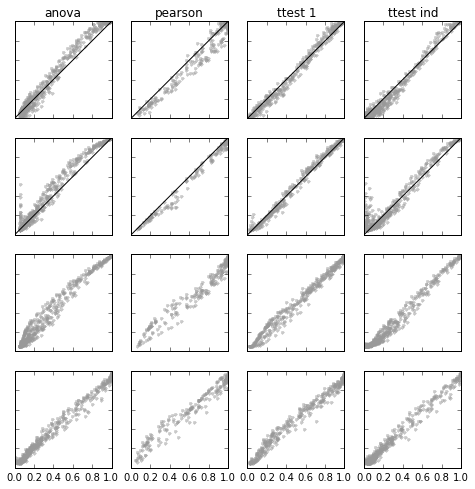

In [21]:
%matplotlib inline

edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax1 = fig.add_subplot(4, 4, idx+1)
    ax2 = fig.add_subplot(4, 4, idx+5)
    ax3 = fig.add_subplot(4, 4, idx+9)
    ax4 = fig.add_subplot(4, 4, idx+13)
    ax1.plot(np.hstack(dists.loc[name, 'trad']),
             np.hstack(dists.loc[name, 'empr']),
             '.', color=[0.6, 0.6, 0.6], alpha=0.5)
    ax2.plot(np.hstack(dists.loc[name, 'trad'])[np.isnan(np.hstack(dists.loc[name, 'extf'])) == False],
             np.hstack(dists.loc[name, 'extf'])[np.isnan(np.hstack(dists.loc[name, 'extf'])) == False],
             '.', color=[0.6, 0.6, 0.6], alpha=0.5)
    ax3.plot(np.hstack(dists.loc[name, 'trad']),
             np.hstack(dists.loc[name, 'extz']),
             '.', color=[0.6, 0.6, 0.6], alpha=0.5)
    ax4.plot(np.hstack(dists.loc[name, 'empr']),
             np.hstack(dists.loc[name, 'extz']),
             '.', color=[0.6, 0.6, 0.6], alpha=0.5)
    ax1.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax2.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax1.set_title(name.replace('_', ' '))
    
    ax1.set_yticklabels('')
    ax2.set_yticklabels('')
    ax3.set_yticklabels('')
    ax4.set_yticklabels('')
   
    ax1.set_xticklabels('')
    ax2.set_xticklabels('')
    ax3.set_xticklabels('')
    
    fig.set_size_inches((8, 8))



In [22]:
effs = pd.DataFrame(np.array(zip(*(zip(*dists.loc['anova', 'pop_params'])[3], 
                                   zip(*dists.loc['anova', 'pop_params'])[4]))),
                    columns=['extrapolated_z', 'traditional_z'])

In [29]:
effs

,extrapolated_z,traditional_z
0,0.343625,0.348090
1,0.613817,0.503512
2,0.450919,0.411316
3,0.354785,0.330444
4,0.112011,0.120577
5,0.081201,0.148675
6,0.444478,0.376198
7,0.300773,0.300359
8,0.538180,0.470186
9,0.177519,0.205908


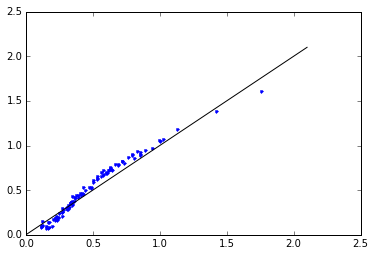

In [34]:
plt.plot(effs['traditional_z'], effs['extrapolated_z'], '.')
plt.plot(np.arange(0, 2.2, 0.1), np.arange(0, 2.2, 0.1), 'k-')


In [25]:
dists.loc['anova', 'empr'][6]

array([ 0.1       ,  0.23      ,  0.31333333,  0.44666667,  0.65333333])

In [26]:
est_ = estimate_z_effect(counts, dists.loc['anova', 'empr'][6])

In [27]:
est_[np.isinf(est_) == False]

array([ 0.42906569,  0.44588893,  0.41678008,  0.43646795,  0.49632992])

In [28]:
fancy_names = {'anova':     'Analysis of Variance',
               'pearson':   "Pearson's R         ",
               'ttest_1':   'One Sample T Test   ',
               'ttest_ind': 'Two Sample T Test   '}
table = ["------------------------------------------------------------------------------------------",
         "         Test           |            Emperical           |          Extrapolated                  ",
         "                        |    m          ci          r    |    m          ci          r      ",
         "------------------------+--------------------------------+--------------------------------"
        ]
for idx, name in enumerate(dists.index.values):
    res = pd.DataFrame(
        np.vstack((np.concatenate(dists.loc[name, 'trad']),
                   np.concatenate(dists.loc[name, 'empr']),
                   np.concatenate(dists.loc[name, 'extz']),
                   )).transpose(),
        columns=['trad', 'empr', 'extr'])
    sub = np.random.choice(res.index, 100, replace=False)
    mod1 = smf.ols('empr ~ trad', data=res.loc[sub]).fit()
    mod2 = smf.ols('extr ~ trad', data=res.loc[sub]).fit()
    mod3 = smf.ols('empr ~ extr', data=res.loc[sub]).fit()

    #     m1, b1, r1, p1, s1 = scipy.stats.linregress(np.hstack(dists.loc[name, 'trad']),
#                                                 np.hstack(dists.loc[name, 'empr']))
#     m2, b2, r2, p2, s2 = scipy.stats.linregress(np.hstack(dists.loc[name, 'trad'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False],
#                                                 np.hstack(dists.loc[name, 'extr'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False])
    
    table.append("  %s  |  %1.2f  [%1.2f, %1.2f]    % 1.3f   %1.2f  [%1.2f, %1.2f]    %1.3f   " 
                 % (fancy_names[name], 
                    mod1.params['trad'], 
                    mod1.conf_int(alpha=0.001).loc['trad', 0], 
                    mod1.conf_int(alpha=0.001).loc['trad', 1], 
                    mod1.rsquared,
                    mod2.params['trad'], 
                    mod2.conf_int(alpha=0.001).loc['trad', 0], 
                    mod2.conf_int(alpha=0.001).loc['trad', 1], 
                    mod2.rsquared))
#                     mod1.rsquared, mod2.rsquared))
table.append("------------------------------------------------------------------------------------------")

print '\n'.join(table)

------------------------------------------------------------------------------------------
         Test           |            Emperical           |          Extrapolated                  
                        |    m          ci          r    |    m          ci          r      
------------------------+--------------------------------+--------------------------------
  Analysis of Variance  |  1.10  [1.04, 1.16]     0.976   1.01  [0.95, 1.07]    0.971   
  Pearson's R           |  1.05  [1.00, 1.10]     0.979   0.95  [0.89, 1.01]    0.966   
  One Sample T Test     |  1.04  [1.00, 1.07]     0.992   0.94  [0.91, 0.98]    0.989   
  Two Sample T Test     |  1.04  [1.00, 1.08]     0.987   0.99  [0.95, 1.02]    0.988   
------------------------------------------------------------------------------------------


It seems like there is a strong correlation between the power calculated using test-based methods, the power calculated by emperical Monte Carlo Simulation, and the extrapolated power usings Statsmodels.


#References

1. <a id="lui2014"></a>Lui, X.S. (2014) *[Statistical power analysis for the social and behavioral sciences: basic and advanced techniques](http://roger.ucsd.edu/search~S9?/Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D/Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D&SUBKEY=statistical+power/1%2C861%2C861%2CE/frameset&FF=Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D&1%2C1%2C)*. New York: Routledge. 378 pg.
2. <a id="zar1999"></a>Zar, J.H. (1999) "Multisample Hypothesis: The Analysis of Variance". Ch. 10. *Biostatistical Analysis*. 4th Ed. Upper Saddle River: Prentice Hall.